## <center> Vehicle Classification </center>

The purpose of the case study is to classify a given silhouette as one of three different types of
vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from
one of many different angles.
Four "Corgie" model vehicles were used for the experiment: a double-decker bus, Chevrolet
van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was
chosen with the expectation that the bus, van and either one of the cars would be readily
distinguishable, but it would be more difficult to distinguish between the cars.

Case file:
vehicle.csv

The points distribution for this case is as follows:
1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5
points)
2. Understanding the attributes - Find the relationship between different attributes (Independent
variables) and choose carefully which all attributes have to be a part of the analysis and why (5
points)
3. Use PCA from scikit learn and elbow plot to find out a reduced number of dimension (which
covers more than 95% of the variance) - 10 points
4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel
= linear, rbf) and find out the best hyperparameters and do cross-validation to find the accuracy.
(10 points)

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

#### Read the data:

In [2]:
vehicles_df = pd.read_csv('vehicle.csv', na_values=' ')

#### View the head:

In [3]:
vehicles_df.head(5)

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

## 1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)

#### View the shape of data:

In [4]:
vehicles_df.shape

(846, 19)

**Inference:**
    
    Data has 846 rows and 19 columns

#### View the count of data under each label:

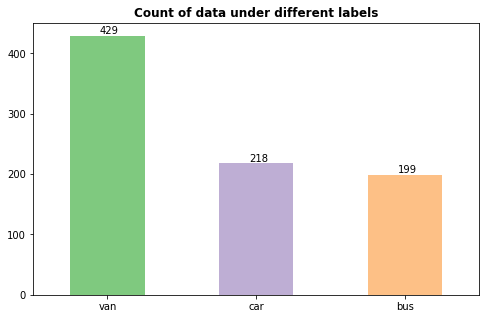

In [5]:
plt.subplots(figsize=(8,5)) 

ax = vehicles_df['class'].value_counts().plot.bar(color=sns.color_palette('Accent',20))
ax.set_title('Count of data under different labels', fontweight = 'bold')
ax.set_xticklabels(labels=vehicles_df['class'].unique(), rotation=0)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+.2,p.get_height()+3))

#### View dataset info:

In [6]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

**Inference:**
    
    All the columns except 'class' are numeric. We will need to encode 'class' data to convert it to numeric

#### Encoding categorical target variable:

In [7]:
print('\n\033[1mBefore Encoding class: \033[0m', vehicles_df['class'].unique())
vehicles_df['class'].replace({'bus':0, 'car':1, 'van':2}, inplace=True)
print('\n\033[1mAfter Encoding class \033[0m:', vehicles_df['class'].unique())


Before Encoding class:  ['van' 'car' 'bus']

After Encoding class : [2 1 0]


#### Check info after encoding:

In [8]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

**Inference:**
    
    All columns are numeric now, so we are good to proceed now

### Check if any data is missing:

In [9]:
vehicles_df.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

**Inference:**
    
    As seen, the below columns have missing values
    
> - circularity <br>
> - distance_circularity <br>
> - radius_ratio <br>
> - pr.axis_aspect_ratio <br>
> - scatter_ratio <br>
> - elongatedness <br>
> - pr.axis_rectangularity <br>
> - scaled_variance <br>
> - scaled_variance.1 <br>
> - scaled_radius_of_gyration <br>
> - scaled_radius_of_gyration.1 <br>
> - skewness_about <br>
> - skewness_about.1 <br>
> - skewness_about.2 <br>

### Before imputing the missing values, I will split the data into train & test, so that there will not be any data leak when the model is built

#### Split data into train & test:

In [10]:
X = vehicles_df.drop('class', axis=1)
y = vehicles_df['class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Missing values in train data:

In [12]:
X_train.isna().sum()

compactness                    0
circularity                    2
distance_circularity           2
radius_ratio                   5
pr.axis_aspect_ratio           1
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                1
scaled_variance.1              0
scaled_radius_of_gyration      1
scaled_radius_of_gyration.1    3
skewness_about                 2
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
dtype: int64

#### Missing values in test data:

In [13]:
X_test.isna().sum()

compactness                    0
circularity                    3
distance_circularity           2
radius_ratio                   1
pr.axis_aspect_ratio           1
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                2
scaled_variance.1              2
scaled_radius_of_gyration      1
scaled_radius_of_gyration.1    1
skewness_about                 4
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
dtype: int64

### Handling missing values in train & test data:

    I will be imputing the missing values with the mean of the corresponding columns in the train data. I will be imputing   the missing values in test data with the mean of train data itself

In [14]:
# Creating a new dataframe to store the mean value of columns from the train data:

val_df = pd.DataFrame(columns=("col_name", "mean_val"))

for col in X_train.columns:
    val_df = val_df.append({'col_name': col, 'mean_val': math.ceil(X_train[col].mean())}, ignore_index=True)
    
val_df

col_name mean_val
0                   compactness       94
1                   circularity       45
2          distance_circularity       82
3                  radius_ratio      169
4          pr.axis_aspect_ratio       62
5       max.length_aspect_ratio        9
6                 scatter_ratio      168
7                 elongatedness       42
8        pr.axis_rectangularity       21
9     max.length_rectangularity      149
10              scaled_variance      188
11            scaled_variance.1      436
12    scaled_radius_of_gyration      175
13  scaled_radius_of_gyration.1       73
14               skewness_about        7
15             skewness_about.1       13
16             skewness_about.2      189
17                hollows_ratio      196

In [15]:
# Function to return the mean value of the column being passed to it:

def get_val(col):
    val = np.asscalar(val_df[val_df['col_name'] == col]['mean_val'].values)
    return val

In [16]:
# Impute missing values in train data:

for col in X_train.columns:
    val = get_val(col)
    X_train[col].fillna(val, inplace=True)

# Impute missing values in test data:
    
for col in X_test.columns:
    val = get_val(col)
    X_test[col].fillna(val, inplace=True)

#### Train data after imputing missing values:

In [17]:
X_train.isna().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
dtype: int64

#### Test data after imputing missing values:

In [18]:
X_test.isna().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
dtype: int64

**Inference:**
    
    No missing values are present. We are good to proceed now

#### Data describe:

In [19]:
vehicles_df.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   
class                        846.0    0.977541    0.702130    0.0    0.00   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0  
class                          1.0    1.0     2.0

**Inference:**
    
- For scatter_ratio, scaled_variance, scaled_variance.1 mean is greater than median indicating a positive skew in the data
- elongatedness, hollows_ratio have mean lesser than median, indicating a mild negative skew
- Other columns would mostly have a normal distribution

#### Let's view the distributions:

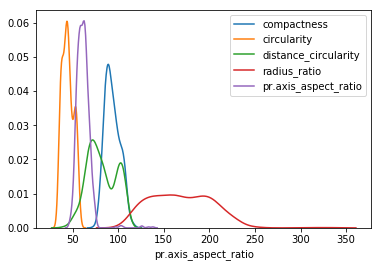

In [20]:
for col in ['compactness', 'circularity', 'distance_circularity', 'radius_ratio', 'pr.axis_aspect_ratio']:
    sns.distplot(vehicles_df[col], hist=False, label=col)

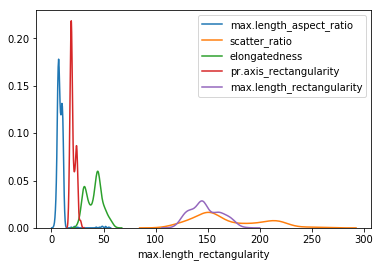

In [21]:
for col in ['max.length_aspect_ratio', 'scatter_ratio', 'elongatedness', 'pr.axis_rectangularity', 'max.length_rectangularity']:
    sns.distplot(vehicles_df[col], hist=False, label=col)

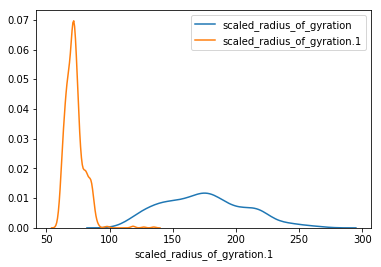

In [22]:
for col in ['scaled_radius_of_gyration', 'scaled_radius_of_gyration.1']:
    sns.distplot(vehicles_df[col], hist=False, label=col)

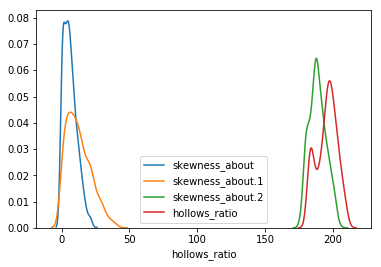

In [23]:
for col in ['skewness_about', 'skewness_about.1', 'skewness_about.2', 'hollows_ratio']:
    sns.distplot(vehicles_df[col], hist=False, label=col)

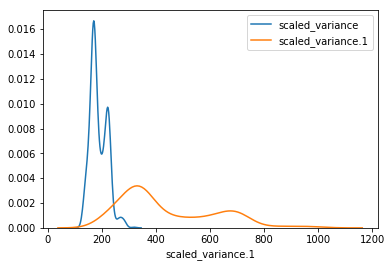

In [24]:
for col in ['scaled_variance', 'scaled_variance.1']:
    sns.distplot(vehicles_df[col], hist=False, label=col)

**Inference:**

    Our inference from the describe function holds good after visualizing the data distribution of the above features

#### Calculating attribute skewness:

In [25]:
print("\033[1mSkewValue of dataframe attributes: \033[0m\n", vehicles_df.skew())

SkewValue of dataframe attributes: 
 compactness                    0.381271
circularity                    0.261809
distance_circularity           0.106585
radius_ratio                   0.394978
pr.axis_aspect_ratio           3.830362
max.length_aspect_ratio        6.778394
scatter_ratio                  0.607271
elongatedness                  0.047847
pr.axis_rectangularity         0.770889
max.length_rectangularity      0.256359
scaled_variance                0.651598
scaled_variance.1              0.842034
scaled_radius_of_gyration      0.279317
scaled_radius_of_gyration.1    2.083496
skewness_about                 0.776519
skewness_about.1               0.688017
skewness_about.2               0.249321
hollows_ratio                 -0.226341
class                          0.031106
dtype: float64


**Inference:**
    
    As seen from the above plots & describe function we can see that features 'max.length_aspect_ratio',                                      'pr.axis_aspect_ratio' & 'scaled_radius_of_gyration.1' have the highest positive skewness

### Check for Outliers using box plot:

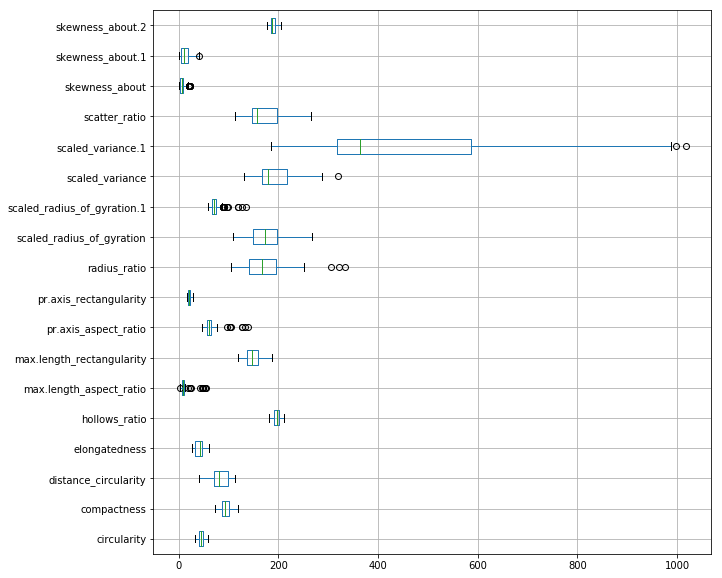

In [26]:
cols = list(vehicles_df.columns.difference(["class"]))
vehicles_df.boxplot(column=cols, vert=False, figsize=(10,10))

From the figure, we can see that the following columns have outliers:

> - skewness_about.1 <br>
> - skewness_about <br>
> - scaled_variance.1 <br>
> - scaled_variance <br>
> - scaled_radius_of_gyration.1 <br>
> - radius_ratio <br>
> - pr.axis_aspect_ratio <br>
> - max.length_aspect_ratio <br>

#### Let's view the outlier columns individually:

#### Columns: skewness_about.1, skewness_about, scaled_radius_of_gyration.1

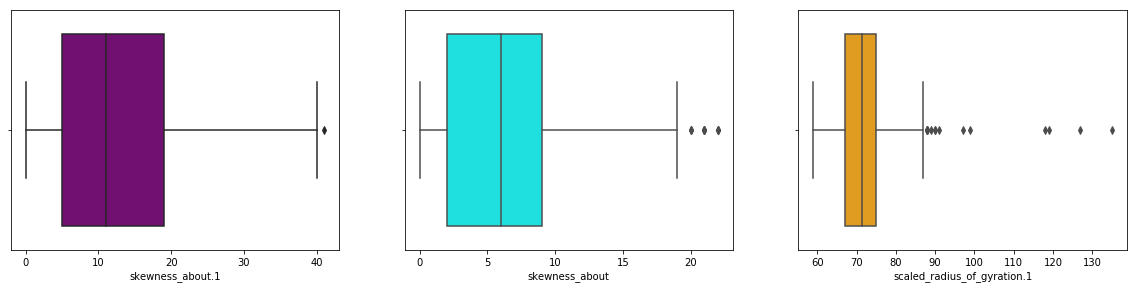

In [27]:
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot('skewness_about.1', data=vehicles_df, color='purple')

plt.subplot(3,3,2)
sns.boxplot('skewness_about', data=vehicles_df, color='cyan')

plt.subplot(3,3,3)
sns.boxplot('scaled_radius_of_gyration.1', data=vehicles_df, color='orange')

#### Columns: radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio

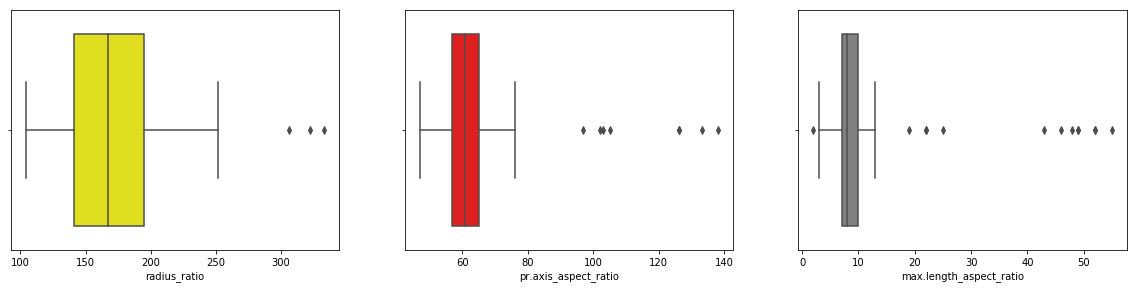

In [28]:
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot('radius_ratio', data=vehicles_df, color="yellow")

plt.subplot(3,3,2)
sns.boxplot('pr.axis_aspect_ratio', data=vehicles_df, color='red')

plt.subplot(3,3,3)
sns.boxplot('max.length_aspect_ratio', data=vehicles_df, color='grey')

#### Columns: scaled_variance.1, scaled_variance

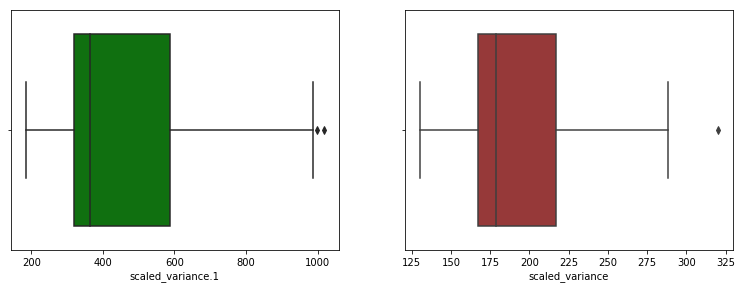

In [29]:
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot('scaled_variance.1', data=vehicles_df, color="green")

plt.subplot(3,3,2)
sns.boxplot('scaled_variance', data=vehicles_df, color='brown')

#### Handling Outliers in train data:

In [30]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

X_train_1 = X_train[~((X_train < (Q1 - 1.5 * IQR)) |(X_train > (Q3 + 1.5 * IQR))).any(axis=1)]

#### Let's view the data after handling outliers in train data:

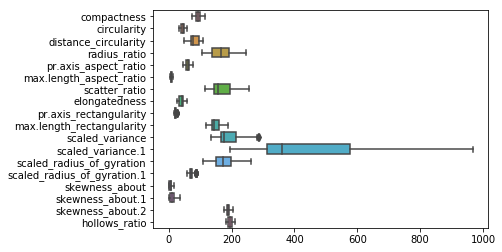

In [31]:
ax = sns.boxplot(data=X_train_1, orient="h")

#### Handling Outliers in test data:

In [32]:
Q1 = X_test.quantile(0.25)
Q3 = X_test.quantile(0.75)
IQR = Q3 - Q1

X_test_1 = X_test[~((X_test < (Q1 - 1.5 * IQR)) |(X_test > (Q3 + 1.5 * IQR))).any(axis=1)]

#### Let's view the data after handling outliers in test data:

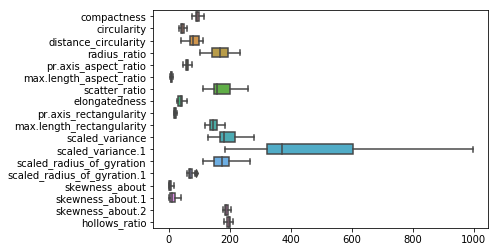

In [33]:
ax = sns.boxplot(data=X_test_1, orient="h")

**Inference:**
    
    We have handled the outliers in both train and test data. So we are good to proceed now

#### Get corresponding target data after handling outliers:

In [34]:
train_set = pd.merge(X_train_1, y_train, how = 'left', left_index = True, right_index = True)
test_set = pd.merge(X_test_1, y_test, how = 'left', left_index = True, right_index = True)

In [35]:
y_train_1 = train_set['class']
y_test_1 = test_set['class']

#### Shape of independent variables - original data & data after handling outliers:

In [36]:
# Train data - original & after handling outliers:
print('\033[1mShape of train data:\033[0m')
print('Original shape               : ', X_train.shape)
print('Shape after handling outliers: ', X_train_1.shape)

# Test data - original & after handling outliers:
print('\n\033[1mShape of test data:\033[0m')
print('Original shape               : ', X_test.shape)
print('Shape after handling outliers: ', X_test_1.shape)

Shape of train data:
Original shape               :  (592, 18)
Shape after handling outliers:  (566, 18)

Shape of test data:
Original shape               :  (254, 18)
Shape after handling outliers:  (245, 18)


#### Shape of target - original data & data after handling outliers:

In [37]:
# Train data - original & after handling outliers:
print('\033[1mShape of target train data:\033[0m')
print('Original shape               : ', y_train.shape)
print('Shape after handling outliers: ', y_train_1.shape)

# Test data - original & after handling outliers:
print('\n\033[1mShape of target test data:\033[0m')
print('Original shape               : ', y_test.shape)
print('Shape after handling outliers: ', y_test_1.shape)

Shape of target train data:
Original shape               :  (592,)
Shape after handling outliers:  (566,)

Shape of target test data:
Original shape               :  (254,)
Shape after handling outliers:  (245,)


#### Shape of train and test data with target - after handling outliers:

In [38]:
print('Newly created train data after handling missing values and outliers: ', train_set.shape)
print('Newly created test data after handling missing values and outliers : ', test_set.shape)

Newly created train data after handling missing values and outliers:  (566, 19)
Newly created test data after handling missing values and outliers :  (245, 19)


## 2. Understanding the attributes - Find the relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)

In [39]:
vehicles_df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio  class  
0             187.0            197      2  
1             189.0            199      2  
2             188.0            196      1  
3             199.0            207      2  
4             180.0            183      0

#### Pairplot:

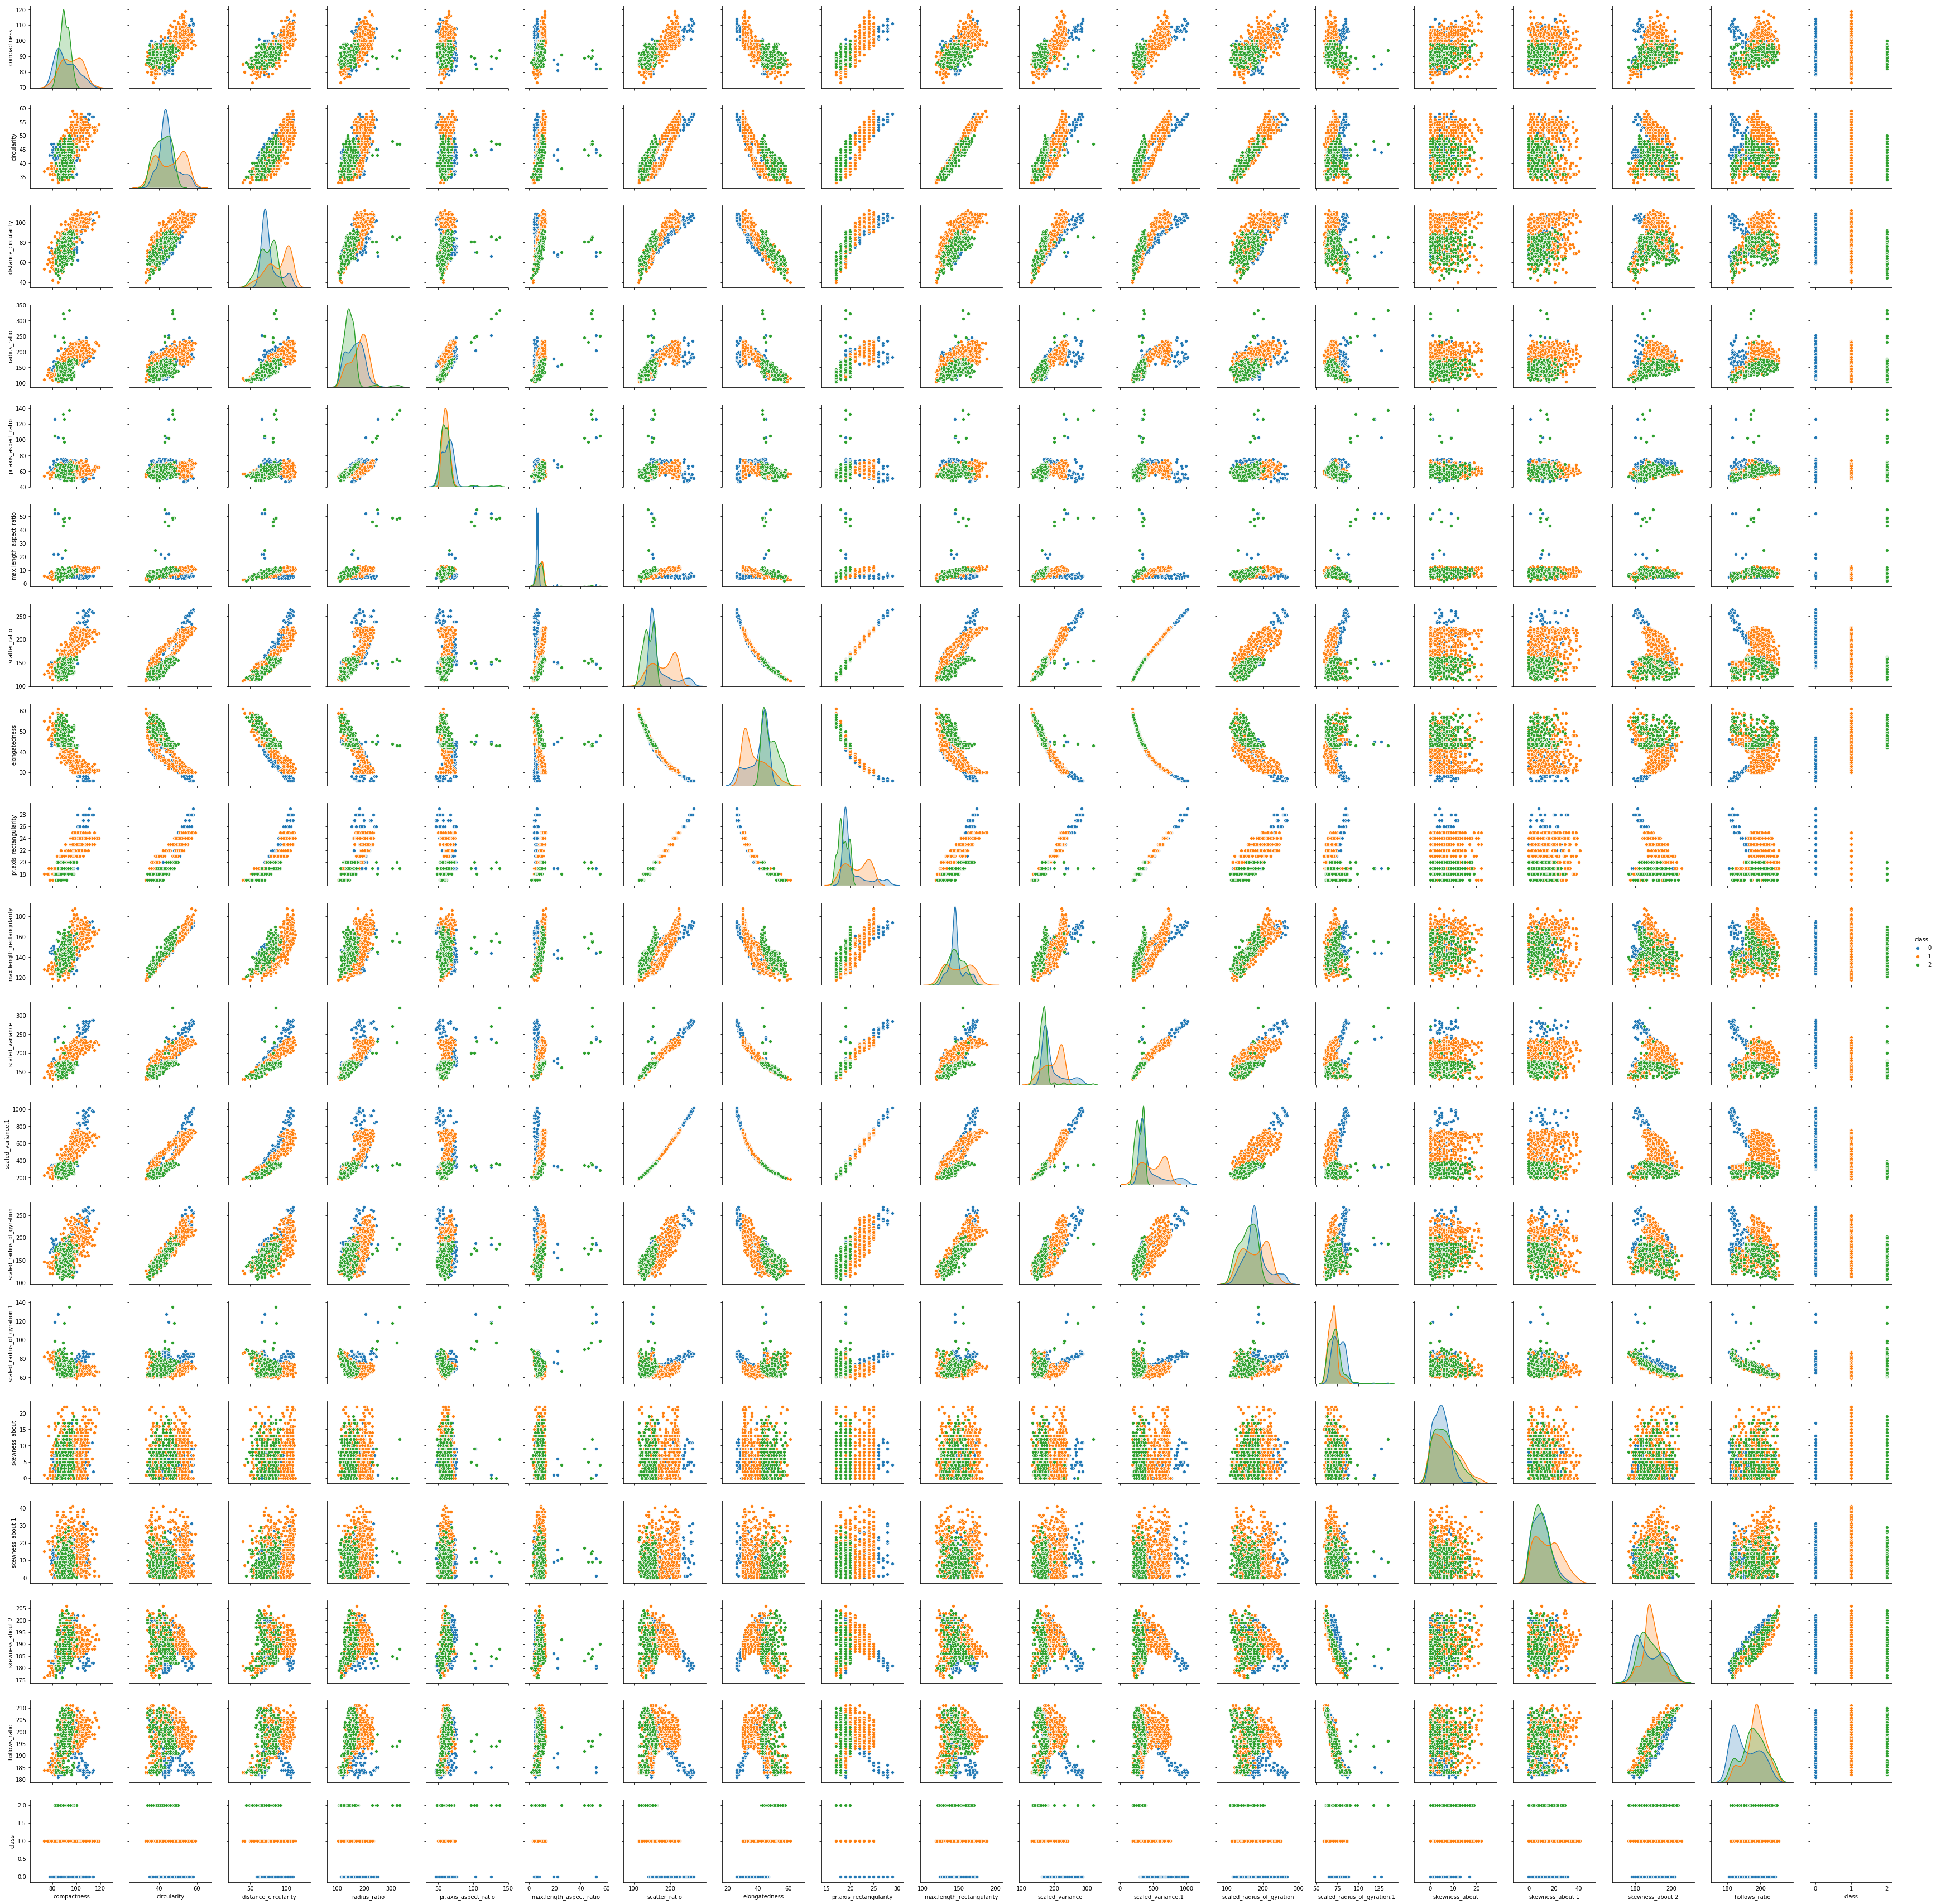

In [40]:
sns.pairplot(vehicles_df, hue="class", diag_kind="kde")

#### Plot correlation using heat map:

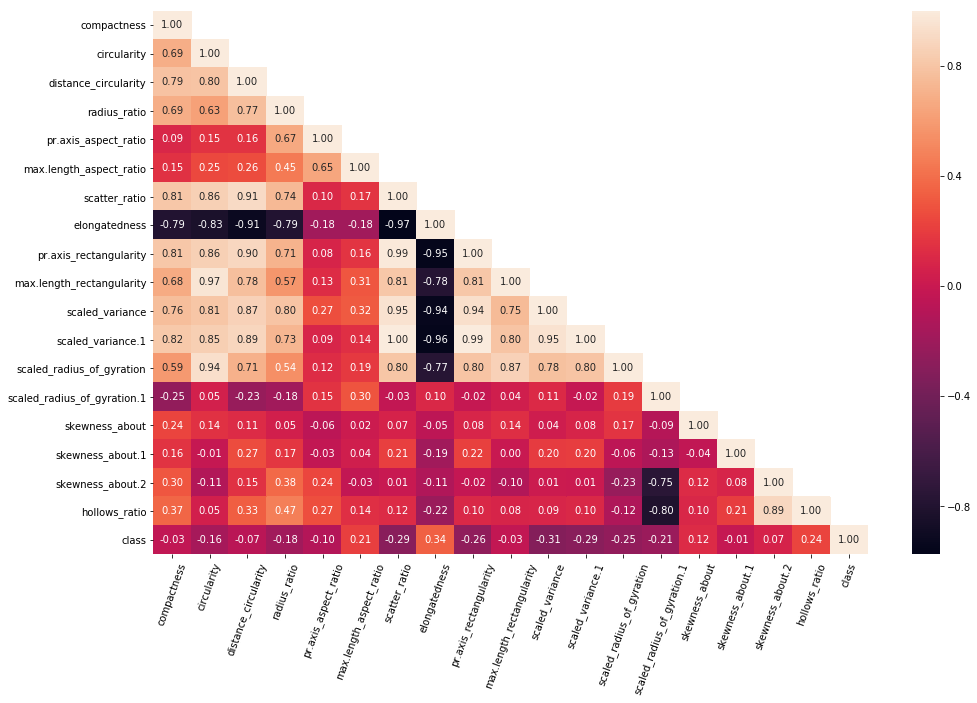

In [41]:
plt.figure(figsize=(16,10))
mask = np.zeros_like(vehicles_df.corr())
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(vehicles_df.corr(), mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=70)

**Inference from above plots:**
    
- scaled_variance.1 and scatter_ratio has a very strong positive correlation
- pr.axis_rectangularity and scatter_ratio has a very strong positive correlation
- scaled_variance and scatter_ratio has a very strong positive correlation 


- elongatedness and scatter_ratio has a strong negative correlation
- elongatedness and scaled_variance.1 has a strong negative correlation
- elongatedness and distance_circularity has a negative correlation

#### Let's look at the correlation now:

In [42]:
# Gets the upper triangle in the correlation matrix
corr_mat = pd.DataFrame(np.triu(vehicles_df.corr().abs(), k=1))  # Values on diagonal (which is 1 here) and below the diagonal
                                                                   # would be converted to 0
corr_mat

# Rename index and columns of the correlation matrix
corr_mat = corr_mat.rename(index=dict(zip(corr_mat.columns, vehicles_df.columns)),
                           columns=dict(zip(corr_mat.columns, vehicles_df.columns)))

#### Check for highly correlated features:

In [43]:
# Create an empty dataframe to store the highly correlated features and their values:
corr_mat_max = pd.DataFrame()

# Get the highly correlated columns and their values:
corr_mat_max['Correlated with'] = corr_mat.idxmax()
corr_mat_max['Max corr value'] = corr_mat.max()

# Sort the dataframe descending to get highly correlated features on top:
corr_mat_max.sort_values(by='Max corr value',ascending=False).head(10)

Correlated with  Max corr value
scaled_variance.1                 scatter_ratio        0.996328
pr.axis_rectangularity            scatter_ratio        0.992078
elongatedness                     scatter_ratio        0.973504
max.length_rectangularity           circularity        0.965729
scaled_variance                   scatter_ratio        0.951672
scaled_radius_of_gyration           circularity        0.935950
scatter_ratio              distance_circularity        0.907949
hollows_ratio                  skewness_about.2        0.893869
distance_circularity                circularity        0.797180
radius_ratio               distance_circularity        0.771748

#### Check for least correlated variables:

In [44]:
#Create an empty dataframe to store the least correlated features and their values:
corr_mat_min = pd.DataFrame()

# Since we are only dealing with the upper triangular correlation matrix, the lower values would be 0. We should not 
# consider these zeroes while finding the least correlation
corr_mat_min['Correlated with'] = corr_mat[corr_mat > 0].idxmin()
corr_mat_min['Min corr value'] = corr_mat[corr_mat > 0].min()

# Sort the dataframe ascending to get the less correlated features on top:
corr_mat_min.sort_values(by='Min corr value').head(10)

Correlated with  Min corr value
skewness_about.1             max.length_rectangularity        0.001660
skewness_about.2                         scatter_ratio        0.005171
class                                 skewness_about.1        0.010674
skewness_about                 max.length_aspect_ratio        0.015446
scaled_radius_of_gyration.1     pr.axis_rectangularity        0.015711
hollows_ratio                              circularity        0.045652
pr.axis_rectangularity            pr.axis_aspect_ratio        0.079566
scaled_variance.1                 pr.axis_aspect_ratio        0.089750
pr.axis_aspect_ratio                       compactness        0.091779
scatter_ratio                     pr.axis_aspect_ratio        0.103832

#### Check for correlation with target:

In [45]:
corr_with_target = pd.DataFrame(vehicles_df.corr().abs().loc['class'])
corr_with_target.drop('class',axis=0,inplace=True) # Drop target as we know self correlation would be 1
corr_with_target.rename(columns={'class': 'Corr value'}, inplace=True)

corr_with_target.sort_values(by='Corr value',ascending=False)

Corr value
elongatedness                  0.339348
scaled_variance                0.312836
scatter_ratio                  0.288904
scaled_variance.1              0.288146
pr.axis_rectangularity         0.259102
scaled_radius_of_gyration      0.250967
hollows_ratio                  0.235874
scaled_radius_of_gyration.1    0.213049
max.length_aspect_ratio        0.207619
radius_ratio                   0.182921
circularity                    0.160546
skewness_about                 0.119652
pr.axis_aspect_ratio           0.098431
skewness_about.2               0.067251
distance_circularity           0.065209
compactness                    0.033796
max.length_rectangularity      0.032399
skewness_about.1               0.010674

**Inference:**
    
- Many columns are highly correlated with each other. 
- Since scatter_ratio has high correlation with few columns, it can be dropped.
- scaled_variance & scaled_variance.1 has a strong positive correlation. One of them can be dropped.

### Overall it can be seen that multicollinearity is high between many independent variables. For example, scaled_variance.1 & scatter_ratio, pr.axis_rectangularity & scatter_ratio, elongatedness & scatter_ratio, max.length_rectangularity & circularity, scaled_variance & scatter_ratio, scaled_radius_of_gyration & circularity have strong positive correlations 

### So, Instead of dropping columns on our own as mentioned in the above inference, we can make use of PCA for dimensionality reduction.

## 3. Use PCA from scikit learn and elbow plot to find out a reduced number of dimension (which covers more than 95% of the variance) - 10 points

#### Standardize data:

In [46]:
sc = StandardScaler()
X_train_std =  sc.fit_transform(X_train_1)     
X_test_std =  sc.fit_transform(X_test_1) 

### PCA:

#### Step 1: Covariance matrix:

In [47]:
# Step 1:

train_cov_matrix = np.cov(X_train_std.T)
print('\033[1mCovariance Matrix: \033[0m\n%s', train_cov_matrix)

Covariance Matrix: 
%s [[ 1.00176991e+00  6.73214726e-01  7.78281020e-01  7.53661404e-01
   2.42944240e-01  4.89859476e-01  8.08186142e-01 -7.86676196e-01
   8.09539343e-01  6.70469799e-01  7.90142552e-01  8.14640518e-01
   5.72111872e-01 -2.69806538e-01  1.88873841e-01  1.46713643e-01
   3.25977345e-01  3.83431656e-01]
 [ 6.73214726e-01  1.00176991e+00  7.91059411e-01  6.41930487e-01
   2.21098016e-01  5.66318353e-01  8.50256253e-01 -8.19665649e-01
   8.46867991e-01  9.62267513e-01  8.05586605e-01  8.41473421e-01
   9.32098346e-01  4.70447424e-02  1.29516233e-01 -5.47452522e-02
  -9.32305744e-02  6.38220496e-02]
 [ 7.78281020e-01  7.91059411e-01  1.00176991e+00  8.10226093e-01
   2.75501108e-01  6.70170962e-01  9.07474760e-01 -9.07027878e-01
   8.97650294e-01  7.71225221e-01  8.82159962e-01  8.91453318e-01
   7.10144611e-01 -2.53300433e-01  1.02793905e-01  2.19179415e-01
   1.44380412e-01  3.35430226e-01]
 [ 7.53661404e-01  6.41930487e-01  8.10226093e-01  1.00176991e+00
   6.89338462e

#### Step 2: Eigen values & Eigen vectors:

In [48]:
# Step 2:

eigenvalues, eigenvectors = np.linalg.eig(train_cov_matrix)
print('\033[1mEigen Vectors: \033[0m \n%s', eigenvectors)
print('\n\033[1m Eigen Values: \033[0m\n%s', eigenvalues)

Eigen Vectors:  
%s [[ 2.70985009e-01  8.89020785e-02 -9.13781794e-04  1.17602016e-01
   1.36502021e-01  2.85972960e-01  1.82141617e-01 -7.68208758e-01
  -3.49738313e-01 -1.40950020e-01  3.79265503e-02 -5.85057555e-02
   2.76377715e-04 -1.12373204e-02 -1.44216614e-01  1.13245792e-01
  -1.40101126e-02 -1.03949948e-02]
 [ 2.84483862e-01 -1.42480902e-01 -2.06791957e-01 -5.27089755e-02
  -9.95020614e-02 -6.58048427e-02 -3.98883989e-01 -5.79813050e-02
  -5.97361092e-02  2.23297939e-01  2.69542326e-02  1.40160081e-01
   4.12784971e-03 -4.39453188e-02 -2.56991167e-01 -2.47628487e-01
  -2.68115438e-01 -6.33660455e-01]
 [ 3.00423886e-01  3.22732698e-02  3.80347538e-02  1.25858211e-01
  -9.60960707e-02 -3.66439621e-02  1.94660239e-01  2.95625541e-01
  -2.52898508e-01 -8.97492643e-03  7.77337570e-01 -2.44654527e-01
  -7.23527356e-03  4.25332508e-02  9.36741983e-02 -2.72503479e-02
   8.58854242e-02 -9.30041892e-02]
 [ 2.74525909e-01  2.00165816e-01  9.43809396e-02 -2.31066318e-01
   1.06254184e-01

#### Step 3: Sort eigenvalues in descending order

In [49]:
# Step 3:

# Make a set of (eigenvalue, eigenvector) pairs
train_eig_pairs = [(eigenvalues[index], eigenvectors[index, :]) for index in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
train_eig_pairs.sort(reverse = True)

train_eig_pairs

[(9.842062255454433,
  array([ 2.70985009e-01,  8.89020785e-02, -9.13781794e-04,  1.17602016e-01,
          1.36502021e-01,  2.85972960e-01,  1.82141617e-01, -7.68208758e-01,
         -3.49738313e-01, -1.40950020e-01,  3.79265503e-02, -5.85057555e-02,
          2.76377715e-04, -1.12373204e-02, -1.44216614e-01,  1.13245792e-01,
         -1.40101126e-02, -1.03949948e-02])),
 (3.342390800874825,
  array([ 0.28448386, -0.1424809 , -0.20679196, -0.05270898, -0.09950206,
         -0.06580484, -0.39888399, -0.05798131, -0.05973611,  0.22329794,
          0.02695423,  0.14016008,  0.00412785, -0.04394532, -0.25699117,
         -0.24762849, -0.26811544, -0.63366046])),
 (1.2402336117104278,
  array([ 0.30042389,  0.03227327,  0.03803475,  0.12585821, -0.09609607,
         -0.03664396,  0.19466024,  0.29562554, -0.25289851, -0.00897493,
          0.77733757, -0.24465453, -0.00723527,  0.04253325,  0.0936742 ,
         -0.02725035,  0.08588542, -0.09300419])),
 (1.1174426895606977,
  array([ 0.27

In [50]:
# Extract the descending ordered eigenvalues and eigenvectors
train_eigvalues_sorted = [train_eig_pairs[index][0] for index in range(len(eigenvalues))]
train_eigvectors_sorted = [train_eig_pairs[index][1] for index in range(len(eigenvalues))]

# Let's confirm our sorting worked, print out eigenvalues
print('\033[1mEigenvalues in descending order: \033[0m %s' %train_eigvalues_sorted)

Eigenvalues in descending order:  [9.842062255454433, 3.342390800874825, 1.2402336117104278, 1.1174426895606977, 0.9043557533567986, 0.6219655574686529, 0.3232355927580017, 0.24015863536669976, 0.1168673622589153, 0.0755834547181703, 0.06178224126958994, 0.04486185172589373, 0.029349124382292337, 0.026788845099564893, 0.01838696183968467, 0.017690635689151947, 0.008346530613058789, 0.0003565029327928047]


#### Create explained_variance & Cumulative_variance_explained:

In [51]:
tot = sum(eigenvalues)

# % of total var_explained
var_explained = [(i / tot) for i in train_eigvalues_sorted] 
# % of total var_explained = [(i / tot) for i in sorted(train_eigvalues_sorted, reverse=True)]  # an array of variance explained by each 


# eigen vector... there will be 18 entries as there are 18 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 18 entries with 18th entry 
# cumulative reaching almost 100%


#### Plot Principal components & Explained variance:

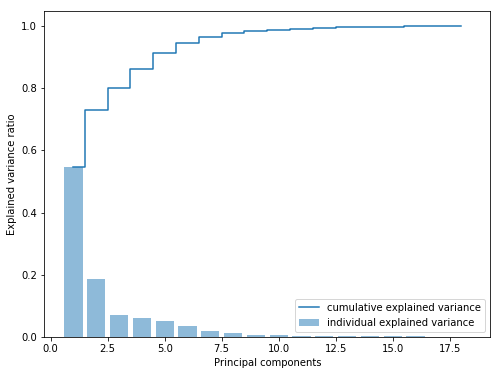

In [52]:
plt.subplots(figsize=(8,6))
plt.bar(range(1,19), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,19),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

**Inference:**
    
- From the above plot, we can find that reducing 18 dimensions to 10 dimensions can cover more than 95% of the variance
- In the next step, we will reduce the dimensions to 10
    

#### Reduced mathematical space:

In [53]:
# P_reduce represents reduced mathematical space....

P_reduce = np.array(train_eigvectors_sorted[0:10])   # Reducing from 18 to 10 dimension space

X_std_4D = np.dot(X_train_std, P_reduce.T)   # projecting original data into principal component dimensions

Proj_data_df = pd.DataFrame(X_std_4D)  # converting array to dataframe for pairplot

#### Let us check it visually:

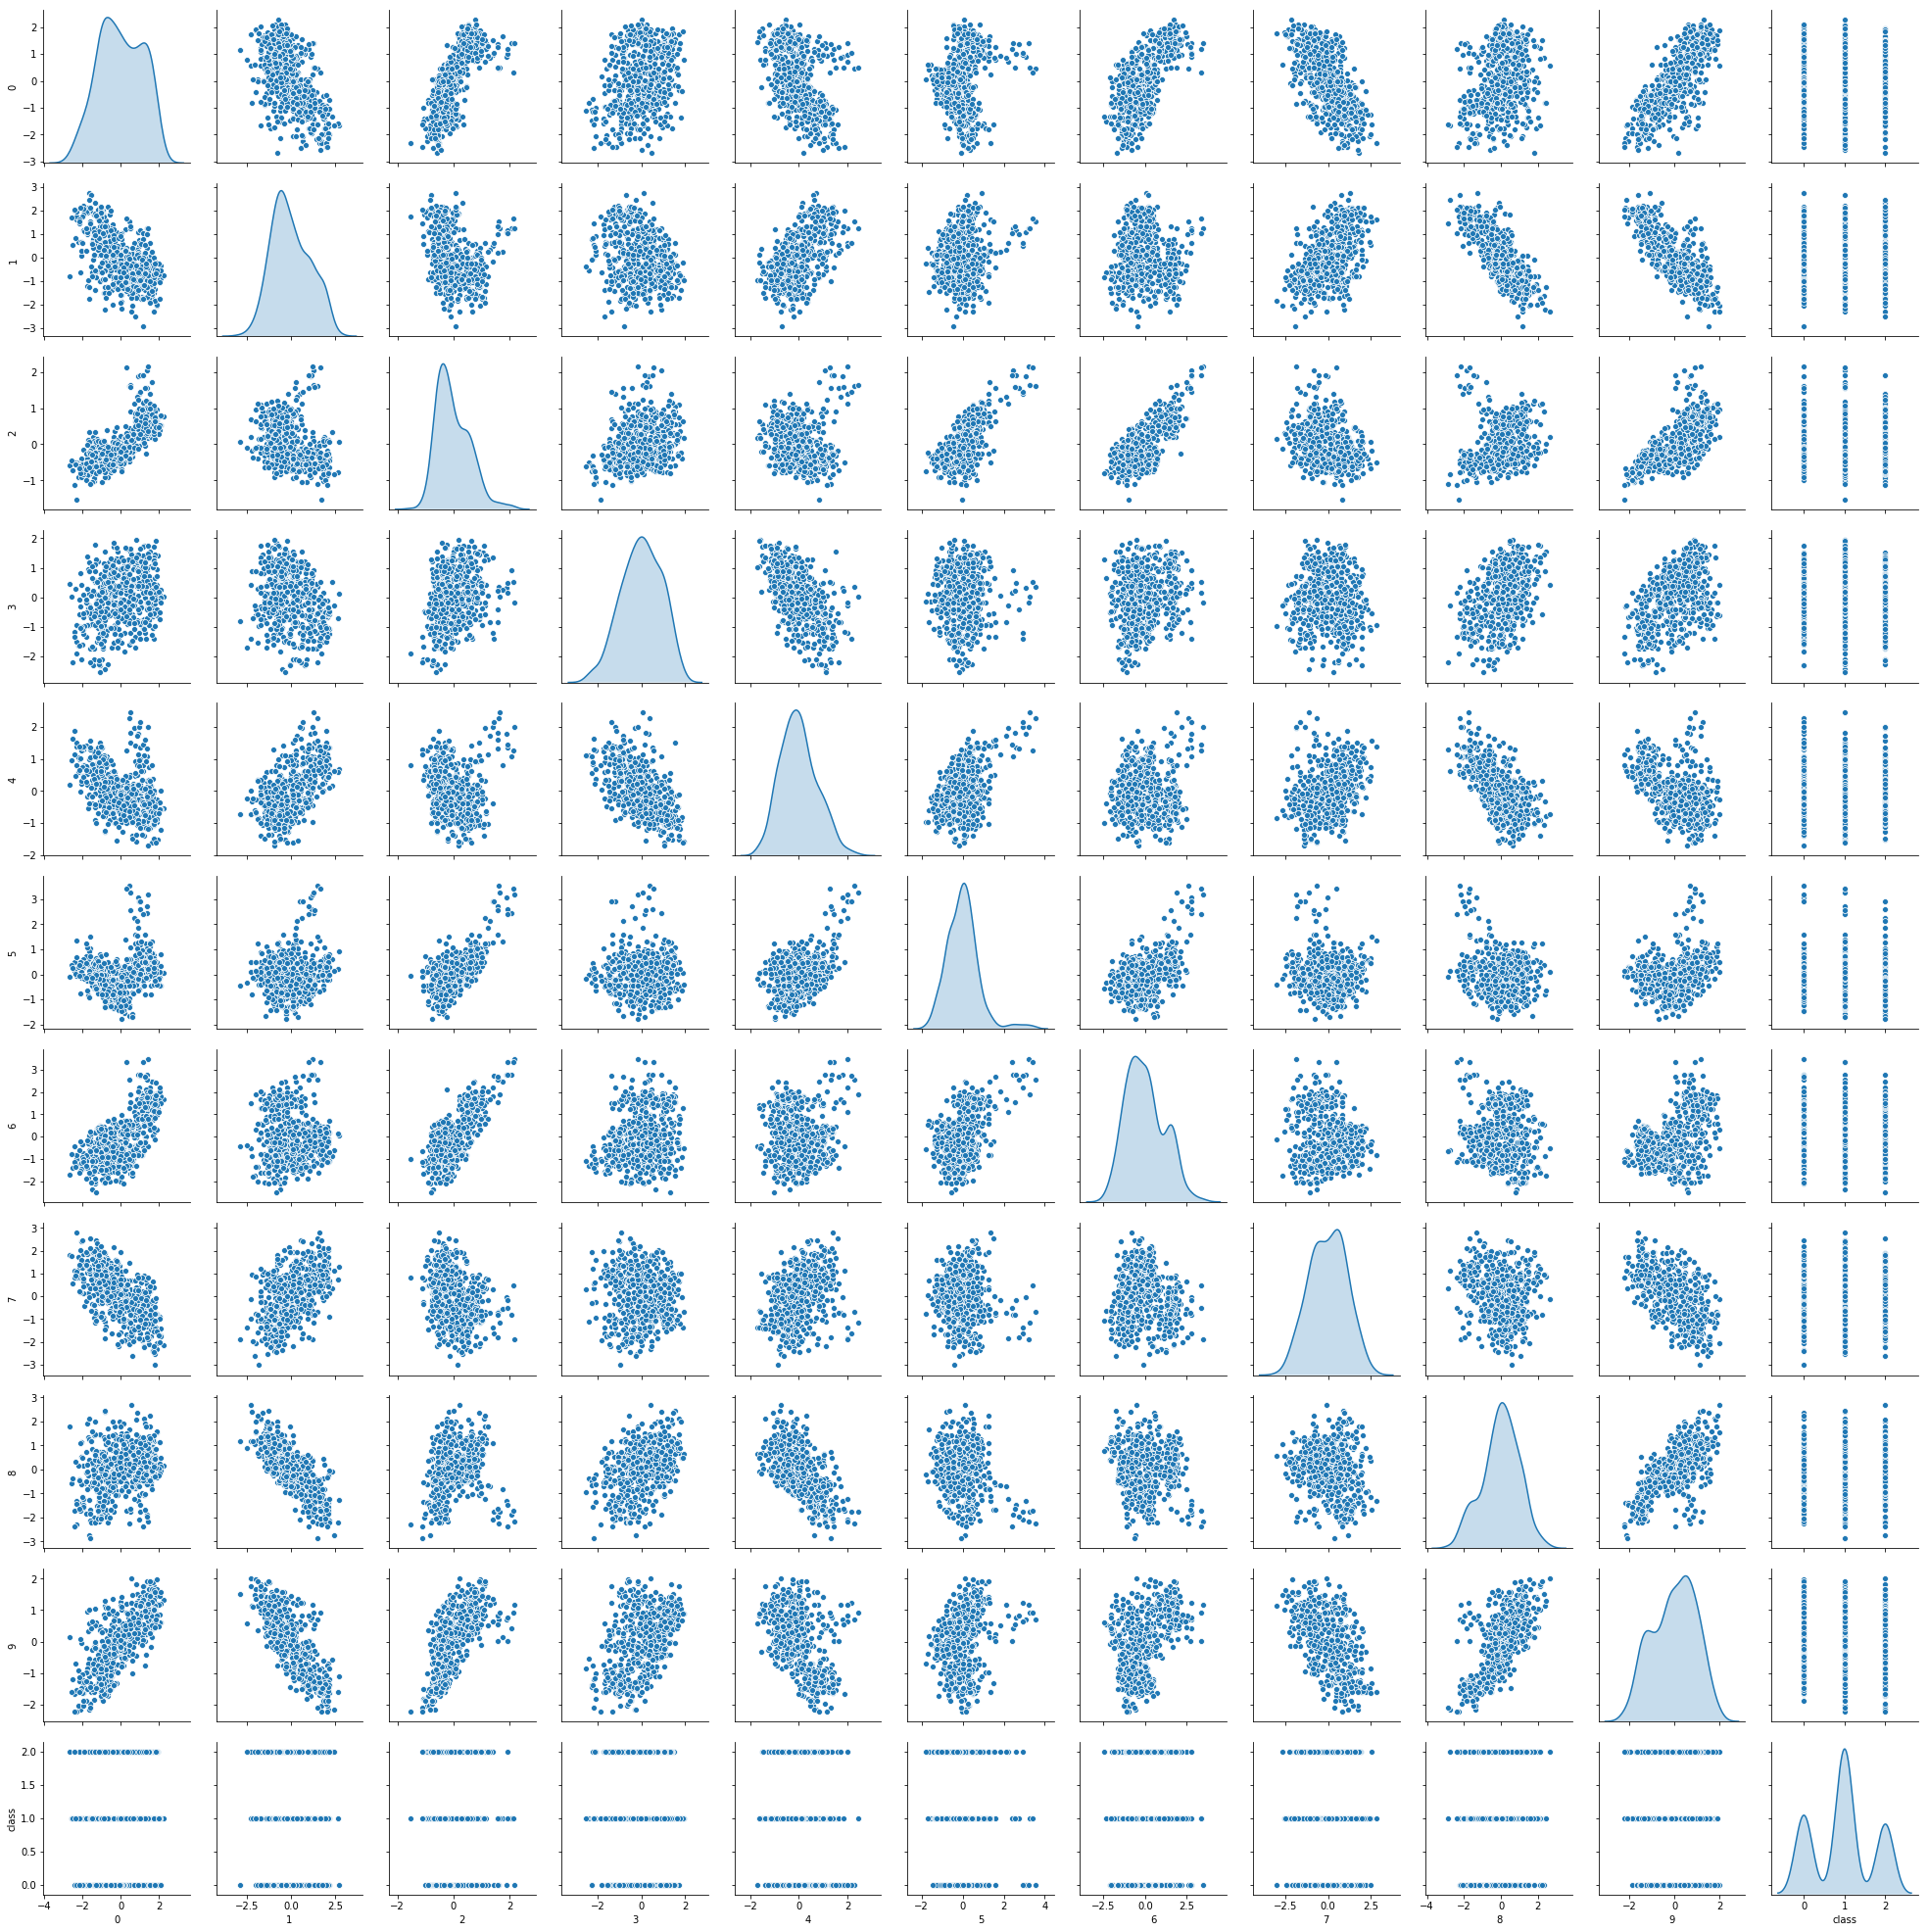

In [54]:
Proj_data_veh_df = Proj_data_df.join(y)

sns.pairplot(Proj_data_veh_df, diag_kind='kde') 

#### Split the newly created dataframe into train and test:

    I wil split the newly created dataframe into train & test to test our model on this test data before running it on the   actual test data

In [55]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(Proj_data_df, y_train_1, test_size=0.30, random_state=10)

## 4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyperparameters and do cross-validation to find the accuracy. (10 points)

### SVM:

### On PCA data:

In [56]:
clf = svm.SVC()    

#### Grid Search:

In [57]:
params = {'C': [0.01, 0.05, 0.5, 1],
          'kernel': ["linear", "rbf"]}

# Making models with hyper parameters sets
model = GridSearchCV(clf, param_grid=params, n_jobs=-1, cv=10) 

# Learning
model.fit(X_train1, y_train1)

# The best hyper parameters set
print('\033[1mBest Hyper Parameters: \033[0m',model.best_params_)

# Prediction
prediction=model.predict(X_test1)

# Accuracy
print('\n\033[1mAccuracy: \033[0m',metrics.accuracy_score(y_test1, prediction))

# Confusion Matrix
print('\n\033[1mConfusion Metrix: \033[0m\n',metrics.confusion_matrix(y_test1, prediction))

Best Hyper Parameters:  {'C': 1, 'kernel': 'rbf'}

Accuracy:  0.9294117647058824

Confusion Metrix: 
 [[45  0  1]
 [ 3 73  5]
 [ 1  2 40]]


### Best hyper parameters are C = 1 and kernel = rbf

#### Applying on original test data:

In [58]:
X_test_std_4D = np.dot(X_test_std, P_reduce.T)   # projecting original data into principal component dimensions

Proj_test_df = pd.DataFrame(X_test_std_4D)  # converting array to dataframe for pairplot

In [59]:
prediction=model.predict(Proj_test_df)

# Accuracy
print('\n\033[1mAccuracy:\033[0m\n',metrics.accuracy_score(y_test_1, prediction))

# Confusion Matrix
print('\n\033[1mConfusion Matrix: \033[0m\n',metrics.confusion_matrix(y_test_1, prediction))

# Classification report
print('\n\033[1mClassification Report: \033[0m\n',classification_report(y_test_1, prediction))


Accuracy:
 0.9428571428571428

Confusion Matrix: 
 [[ 56   1   2]
 [  6 127   3]
 [  1   1  48]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92        59
           1       0.98      0.93      0.96       136
           2       0.91      0.96      0.93        50

    accuracy                           0.94       245
   macro avg       0.93      0.95      0.94       245
weighted avg       0.95      0.94      0.94       245



#### Cross validation:

In [60]:
# Cross validation:

kfold = KFold(n_splits=20, random_state=10)
model = svm.SVC(C=1.0, kernel='rbf', random_state=10)  
results = cross_val_score(model, Proj_test_df, y_test_1, cv=kfold)
print(results)
print("\n\033[1mAccuracy: \033[0m %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.61538462 0.76923077 0.76923077 0.92307692 0.92307692 1.
 0.91666667 1.         0.91666667 0.91666667 1.         0.91666667
 1.         0.83333333 0.83333333 1.         0.91666667 0.91666667
 0.91666667 0.91666667]

Accuracy:  90.000% (9.418%)


#### Plotting confusion matrix:

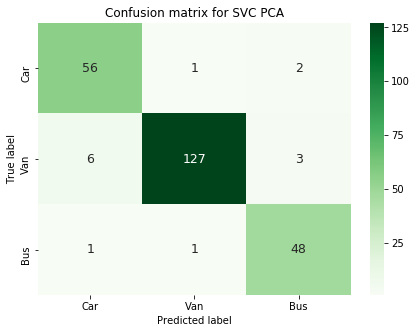

In [61]:
svc_pca_cm = confusion_matrix(y_test_1, prediction)
svc_pca_cm = pd.DataFrame(svc_pca_cm,
                  index = ["Car", "Van", "Bus"], 
                  columns = ["Car", "Van", "Bus"])

plt.figure(figsize=(7,5))
sns.heatmap(svc_pca_cm, annot=True, annot_kws={"fontsize":12.5}, cmap='Greens', fmt='d')
plt.title('Confusion matrix for SVC PCA')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [62]:
test_set.shape

(245, 19)

#### Analyzing the confusion matrix:

In test data, totally we have 245 datapoints <br>
Sum of all values in confusion matrix is equal to 245

- Totally there are 59 Cars, out of which 56 were predicted correctly by our model and the remaining 3 were wrongly predicted. 1 was wrongly predicted as Van and 2 were wrongly predicted as Bus
- Totally there are 136 Vans, out of which 127 were predicted correctly by our model and the remaining 9 were wrongly predicted. 6 were wrongly predicted as Car and 3 were wrongly predicted as Bus
- Totally there are 50 Buses, out of which 48 were predicted correctly by our model and the remaining 2 were wrongly predicted as Van & Bus

### SVM - On original data (Without PCA):

In [63]:
clf1 = svm.SVC()    

In [64]:
print(X_train_std.shape)
print(X_test_std.shape)
print(y_train_1.shape)
print(y_test_1.shape)

(566, 18)
(245, 18)
(566,)
(245,)


#### Grid Search:

In [65]:
params = {'C': [0.01, 0.05, 0.5, 1],
          'kernel': ["linear", "rbf"]}

# Making models with hyper parameters sets
model1 = GridSearchCV(clf1, param_grid=params, n_jobs=-1, cv=10) 

# Learning
model1.fit(X_train_std, y_train_1)

# The best hyper parameters set
print('\033[1mBest Hyper Parameters: \033[0m',model1.best_params_)

# Prediction
prediction=model1.predict(X_test_std)

# Accuracy
print('\n\033[1mAccuracy: \033[0m',metrics.accuracy_score(y_test_1, prediction))

# Confusion Matrix
print('\n\033[1mConfusion Matrix: \033[0m\n',metrics.confusion_matrix(y_test_1, prediction))

# Classification report
print('\n\033[1mClassification Report: \033[0m\n',classification_report(y_test_1, prediction))

Best Hyper Parameters:  {'C': 1, 'kernel': 'rbf'}

Accuracy:  0.9755102040816327

Confusion Matrix: 
 [[ 59   0   0]
 [  2 131   3]
 [  1   0  49]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        59
           1       1.00      0.96      0.98       136
           2       0.94      0.98      0.96        50

    accuracy                           0.98       245
   macro avg       0.96      0.98      0.97       245
weighted avg       0.98      0.98      0.98       245



### Best hyper parameters are C = 1 and kernel = rbf

#### Cross validation:

In [66]:
# Cross validation:

kfold = KFold(n_splits=20, random_state=10)
model1 = svm.SVC(C=1.0, kernel='rbf', random_state=10)  
results = cross_val_score(model1, X_test_std, y_test_1, cv=kfold)
print(results)
print("\n\033[1mAccuracy: \033[0m %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.92307692 0.92307692 0.84615385 0.92307692 0.92307692 1.
 0.83333333 1.         0.91666667 1.         1.         0.91666667
 1.         0.91666667 0.91666667 1.         1.         1.
 1.         1.        ]

Accuracy:  95.192% (5.323%)


#### Plotting confusion matrix:

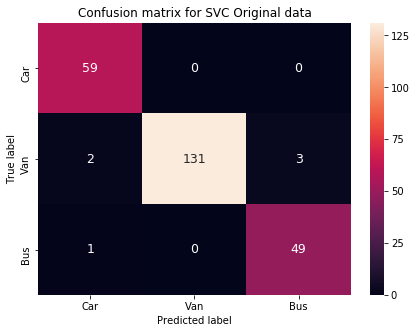

In [67]:
svc_orig_cm = confusion_matrix(y_test_1, prediction)
svc_orig_cm = pd.DataFrame(svc_orig_cm,
                  index = ["Car", "Van", "Bus"], 
                  columns = ["Car", "Van", "Bus"])

plt.figure(figsize=(7,5))
sns.heatmap(svc_orig_cm, annot=True, annot_kws={"fontsize":12.5}, cmap='rocket', fmt='d')
plt.title('Confusion matrix for SVC Original data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Analyzing the confusion matrix:

In test data, totally we have 245 datapoints <br>
Sum of all values in confusion matrix is equal to 245

- Totally there are 59 Cars and all of them were predicted correctly by our model.
- Totally there are 136 Vans, out of which 131 were predicted correctly by our model and the remaining 5 were wrongly predicted. 2 were wrongly predicted as Car and 3 were wrongly predicted as Bus
- Totally there are 50 Buses, out of which 49 were predicted correctly by our model and the remaining 1 was wrongly predicted as Car

### Overall Summary:

- Read the vehicles data. Data had 846 rows and 19 columns
- Multiclass classification with target to be predicted as 'Bus', 'Car' or 'Van'
- All features are numeric, except target 'class' which was converted to numeric
- Missing values were present in the data and outliers were present
- Original data was split into train and test and then missing values were imputed using mean and outliers were handled. This was done so as to avoid data leakage to the model
- Univariate and bivariate analysis was done
- Correlation between features and target and multicollinearity were examined
- Instead of manually removing the features with high multicollinearity, PCA was performed for dimensionality reduction
- Data was standardized using standard scalar before perfoming PCA
- PCA was performed on data by which 18 dimensions were reduced to 10 which could cover more than 95% of variance
- SVM was used with Grid search and cross validation and it gave an accuracy of 94% on test data after PCA
- Same SVM model was used for the original data without performing PCA and it gave an accuracy of 98% on test data 
- Cross validated score of SVM with PCA was found to be 90% and that on original data was found to be 95% for the vehicles data

## <center> End of R6 Vehicle classification Unsupervised Learning Assignment </center>